In [1]:
pip install pyro-ppl torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 8.0 MB/s eta 0:00:00


In [2]:
from google.colab import files
uploaded = files.upload()


Saving Advertising.csv to Advertising.csv


In [3]:
import pandas as pd

# Load the dataset (name must match the uploaded file)
df = pd.read_csv('Advertising.csv')

# Check if the dataset loaded correctly
print(df.head())


      TV  Radio  Newspaper  Sales
0  230.1   37.8       69.2   22.1
1   44.5   39.3       45.1   10.4
2   17.2   45.9       69.3    9.3
3  151.5   41.3       58.5   18.5
4  180.8   10.8       58.4   12.9


In [4]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, EmpiricalMarginal, Predictive
from pyro.optim import Adam
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt



In [5]:
uploaded = files.upload()


df = pd.read_csv('Advertising.csv')

X = torch.tensor(df[['TV', 'Radio', 'Newspaper']].values, dtype=torch.float)
Y = torch.tensor(df['Sales'].values, dtype=torch.float)


Saving Advertising.csv to Advertising (1).csv


In [6]:
X.shape[-1]

3

In [7]:
def model(X, Y):
    slope = pyro.sample('slope', dist.Normal(torch.zeros(X.shape[-1]), torch.ones(X.shape[-1])).to_event(1))
    intercept = pyro.sample('intercept', dist.Normal(0.0, 1.0))
    sigma = pyro.sample('sigma', dist.LogNormal(0.0, 0.5))

    mean = torch.matmul(X, slope) + intercept

    with pyro.plate('data', X.shape[0]):
        obs = pyro.sample('obs', dist.Normal(mean, sigma), obs=Y)

def guide(X, Y):
    slope_loc = pyro.param('slope_loc', torch.zeros(X.shape[-1]))
    slope_scale = pyro.param('slope_scale', torch.ones(X.shape[-1]), constraint=dist.constraints.positive)

    intercept_loc = pyro.param('intercept_loc', torch.tensor(0.0))
    intercept_scale = pyro.param('intercept_scale', torch.tensor(1.0), constraint=dist.constraints.positive)
    sigma_loc = pyro.param('sigma_loc', torch.tensor(1.0), constraint=dist.constraints.positive)

    slope = pyro.sample('slope', dist.Normal(slope_loc, slope_scale).to_event(1))
    intercept = pyro.sample('intercept', dist.Normal(intercept_loc, intercept_scale))
    sigma = pyro.sample('sigma', dist.LogNormal(sigma_loc, torch.tensor(1.0)))


Step 0 : Loss = 88239.46389937401
Step 100 : Loss = 212942.9038810134
Step 200 : Loss = 59379.512244582176
Step 300 : Loss = 6290.620333850384
Step 400 : Loss = 6844.409058570862
Step 500 : Loss = 3257.5606820583344
Step 600 : Loss = 98737.64462208748
Step 700 : Loss = 6594.087357401848
Step 800 : Loss = 1683.5402083396912
Step 900 : Loss = 39130.92545503378


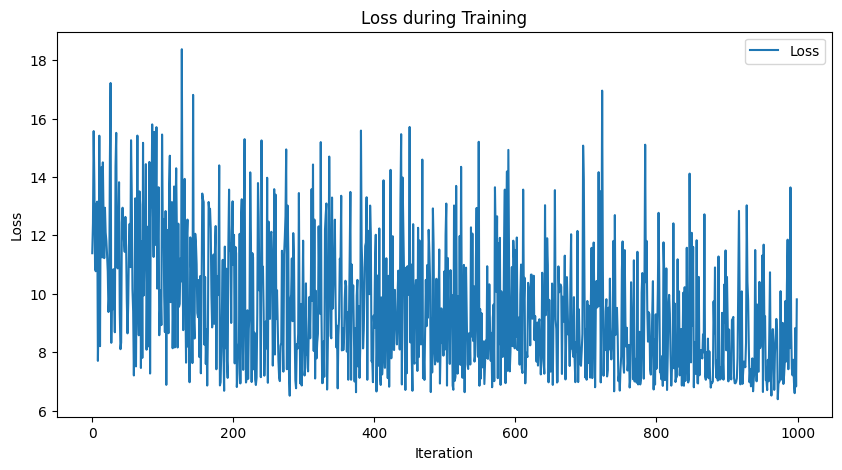

In [8]:
import numpy as np
optim = Adam({"lr": 0.01})

svi = SVI(model, guide, optim, loss=Trace_ELBO())

num_iterations = 1000
losses = []
for step in range(num_iterations):
    loss = svi.step(X, Y)
    losses.append(np.log(loss))
    if step % 100 == 0:
        print(f"Step {step} : Loss = {loss}")

slope_est = pyro.param('slope_loc').detach().numpy()
intercept_est = pyro.param('intercept_loc').item()
sigma_est = pyro.param('sigma_loc').item()

plt.figure(figsize=(10, 5))
plt.plot(losses, label='Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss during Training')
plt.legend()
plt.show()

In [9]:
print(f"Estimated Slope: {slope_est}")
print(f"Estimated Intercept: {intercept_est}")
print(f"Estimated Sigma: {sigma_est}")

Estimated Slope: [0.03423629 0.06576429 0.03339607]
Estimated Intercept: 0.04798766225576401
Estimated Sigma: 2.601984739303589


In [10]:
for name, value in pyro.get_param_store().items():
    print(name, value.detach().numpy())

slope_loc [0.03423629 0.06576429 0.03339607]
slope_scale [0.48250985 0.7280648  0.503546  ]
intercept_loc 0.047987662
intercept_scale 1.1186368
sigma_loc 2.6019847


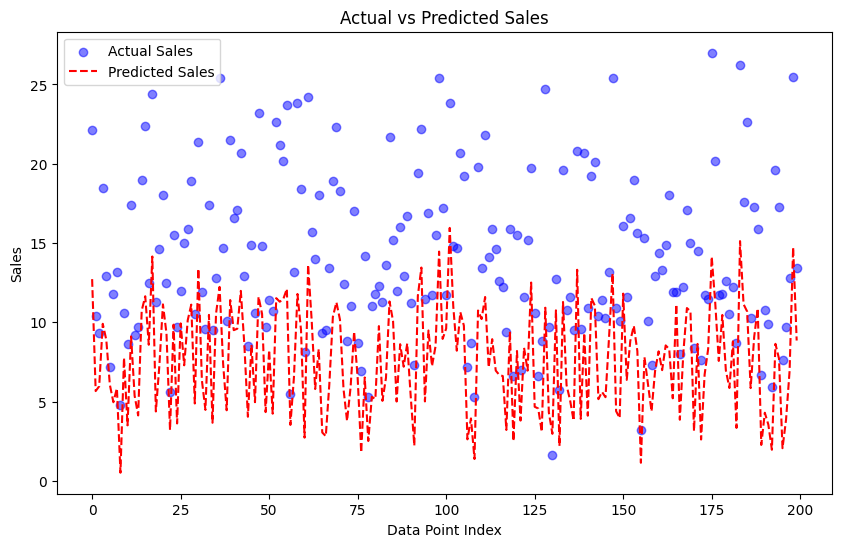

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
Y_pred = torch.matmul(X, torch.tensor(slope_est)) + intercept_est

plt.figure(figsize=(10, 6))
plt.scatter(range(len(Y)), Y, label="Actual Sales", color='blue', alpha=0.5)
plt.plot(range(len(Y_pred)), Y_pred, label="Predicted Sales", color='red', linestyle='dashed')
plt.xlabel('Data Point Index')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales')
plt.legend()
plt.show()

In [12]:

num_samples = 100
predictive = Predictive(model, guide=guide, num_samples=num_samples)
svi_samples = {k: v.reshape(num_samples, -1).detach().cpu().numpy()
               for k, v in predictive(X, Y).items() if k != 'obs'}



In [13]:
import numpy as np
from pyro.infer import Predictive
mean_samples = {k: np.mean(v, axis=0) for k, v in svi_samples.items()}

print("Mean Samples:")
for site_name, mean_value in mean_samples.items():
    print(f"{site_name}: {mean_value}")

Mean Samples:
slope: [0.02397675 0.08163567 0.08267958]
intercept: [0.00690815]
sigma: [20.655735]


Step 0 : Loss = 678.8340342640877
Step 100 : Loss = 597.25818836689
Step 200 : Loss = 498.4854516386986
Step 300 : Loss = 739.7466111183167
Step 400 : Loss = 496.06988030672073
Step 500 : Loss = 672.9820826053619
Step 600 : Loss = 545.9805043339729
Step 700 : Loss = 423.52723520994186
Step 800 : Loss = 503.0350516438484
Step 900 : Loss = 881.0131480097771


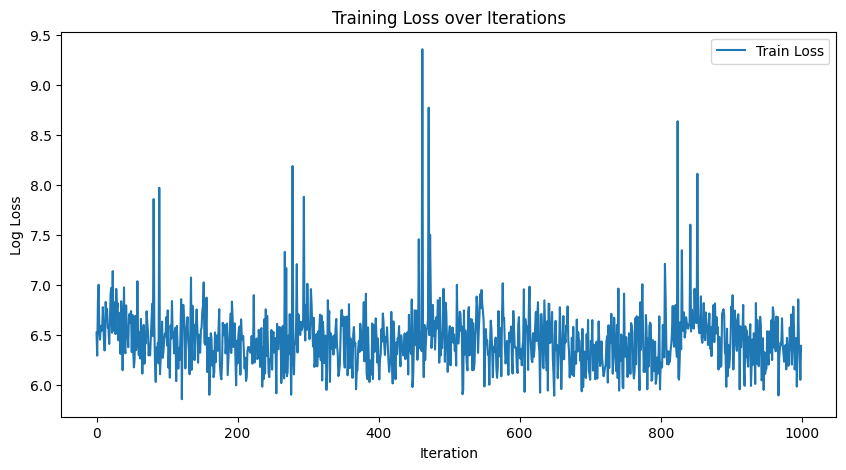

Estimated Slope: [0.04667344 0.2088784  0.02978849]
Estimated Intercept: 0.42764708399772644
Estimated Sigma: 2.4230103492736816


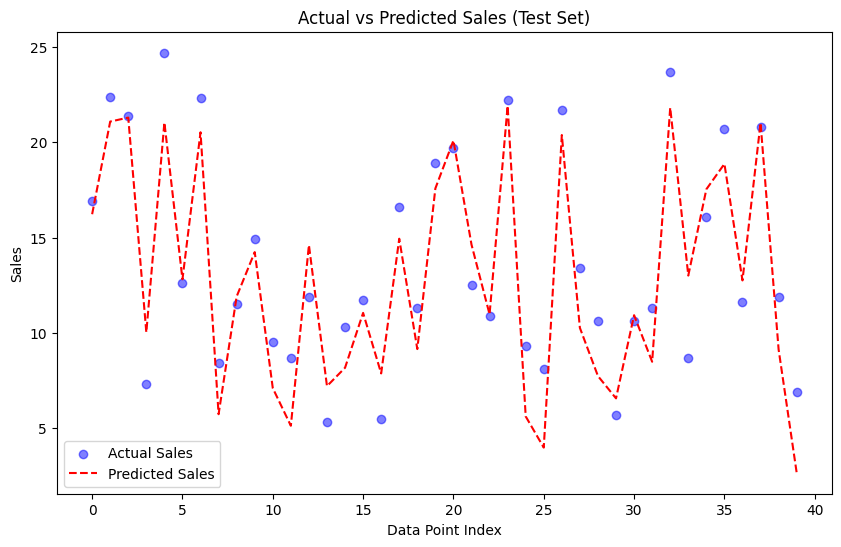

Standard deviation values: [1.67846680e-04 2.23159790e-04 2.15530396e-04 6.67572021e-05
 1.73568726e-04 9.25064087e-05 1.06811523e-04 5.72204590e-05
 0.00000000e+00 1.39236450e-04 0.00000000e+00 8.67843628e-05
 7.43865967e-05 1.81198120e-05 1.03950500e-04 1.14440918e-04
 0.00000000e+00 1.64031982e-04 1.11579895e-04 1.92642212e-04
 1.90734863e-05 0.00000000e+00 4.57763672e-05 1.04904175e-04
 9.44137573e-05 6.77108765e-05 8.77380371e-05 1.09672546e-04
 3.62396240e-05 3.05175781e-05 3.62396240e-05 1.11579895e-04
 1.46865845e-04 8.67843628e-05 1.58309937e-04 5.53131104e-05
 6.67572021e-05 5.72204590e-05 7.43865967e-05 6.34192475e-05]


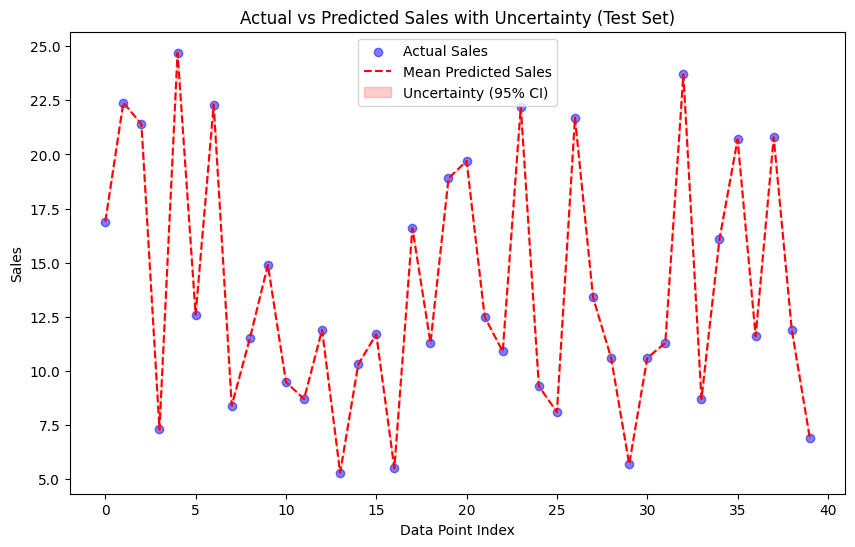

Test Loss: 173.8813123703003


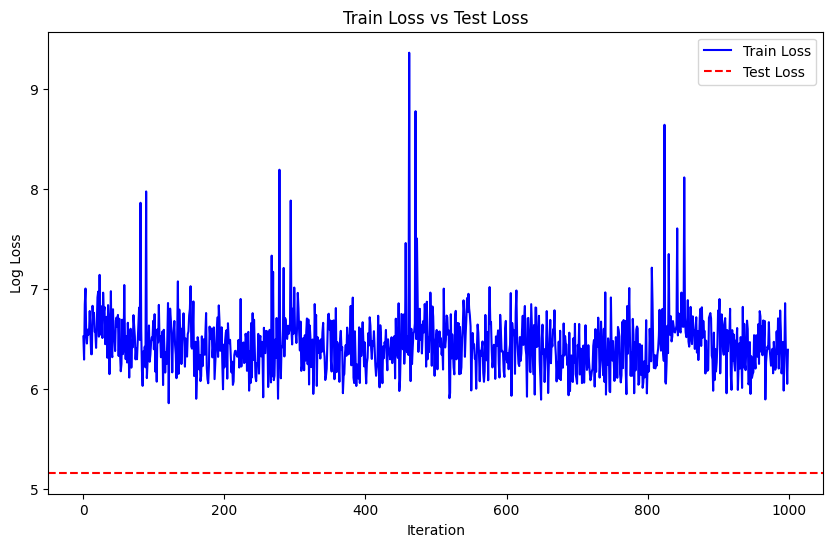

In [17]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

optim = Adam({"lr": 0.01})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

num_iterations = 1000
train_losses = []
for step in range(num_iterations):
    loss = svi.step(X_train, Y_train)
    train_losses.append(np.log(loss))
    if step % 100 == 0:
        print(f"Step {step} : Loss = {loss}")

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Iteration')
plt.ylabel('Log Loss')
plt.title('Training Loss over Iterations')
plt.legend()
plt.show()

slope_est = pyro.param('slope_loc').detach().numpy()
intercept_est = pyro.param('intercept_loc').item()
sigma_est = pyro.param('sigma_loc').item()

print(f"Estimated Slope: {slope_est}")
print(f"Estimated Intercept: {intercept_est}")
print(f"Estimated Sigma: {sigma_est}")

Y_pred_test = torch.matmul(X_test, torch.tensor(slope_est)) + intercept_est

plt.figure(figsize=(10, 6))
plt.scatter(range(len(Y_test)), Y_test, label="Actual Sales", color='blue', alpha=0.5)
plt.plot(range(len(Y_pred_test)), Y_pred_test, label="Predicted Sales", color='red', linestyle='dashed')
plt.xlabel('Data Point Index')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales (Test Set)')
plt.legend()
plt.show()

import torch
import numpy as np
import matplotlib.pyplot as plt
from pyro.infer import Predictive

num_samples = 1000  # Increasing the number of samples for more accurate uncertainty estimation
predictive = Predictive(model, guide=guide, num_samples=num_samples)
predictions = predictive(X_test, Y_test)
Y_pred_samples = predictions['obs'].detach().numpy()

mean_pred = np.mean(Y_pred_samples, axis=0)
std_pred = np.std(Y_pred_samples, axis=0)

# Print the standard deviation values to inspect the spread
print(f"Standard deviation values: {std_pred}")

plt.figure(figsize=(10, 6))
plt.scatter(range(len(Y_test)), Y_test, label="Actual Sales", color='blue', alpha=0.5)
plt.plot(range(len(mean_pred)), mean_pred, label="Mean Predicted Sales", color='red', linestyle='dashed')

# Fill between for uncertainty visualization (showing 95% confidence intervals)
plt.fill_between(range(len(mean_pred)),
                 mean_pred - 2 * std_pred,  # 95% CI -> mean ± 2 * std
                 mean_pred + 2 * std_pred,
                 color='red', alpha=0.2, label='Uncertainty (95% CI)')

plt.xlabel('Data Point Index')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales with Uncertainty (Test Set)')
plt.legend()
plt.show()


test_loss = svi.evaluate_loss(X_test, Y_test)
print(f"Test Loss: {test_loss}")

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.axhline(y=np.log(test_loss), color='red', linestyle='--', label='Test Loss')
plt.xlabel('Iteration')
plt.ylabel('Log Loss')
plt.title('Train Loss vs Test Loss')
plt.legend()
plt.show()
